In [1]:
import numpy as np
import tensorflow as tf

from scipy import stats
from sklearn.metrics import r2_score
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns

# Data
from data.data_generator import data_generator
from data.data_generator import data_model
from data.data_filtering import (sanity_checks, est_sanity_checks, sample_sanity_checks)

# Model
from models.models import HeteroskedasticModel
from models.models import BayesFlow

# Utils
from utils.losses import heteroskedastic_loss, maximum_likelihood_loss
from utils.training import train_step
from utils.viz import (plot_true_est_scatter, plot_true_est_posterior, 
                       plot_correlation_parameters, plot_comp_post_prior, plot_ppc)

%load_ext autoreload
%autoreload 2

In [2]:
# Using Heteroskedastic model as summary net
class SummaryNet(tf.keras.Model):
    def __init__(self, meta):
        super(CustomSummaryNetwork, self).__init__()
        pass
    
    def call(self, x):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|params)
        """
        
        # Do something with input
        return x

### Training Hyperparameters

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'n_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$\delta$', r'$\rho$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR_eta"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

### Test Data

In [4]:
%%time
data_test = data_generator(n_test)

# Preprocessing untrained data
x_test = np.array(data_test['x'])
theta_test = np.array(data_test['theta'])

CPU times: user 131 ms, sys: 1.89 ms, total: 133 ms
Wall time: 137 ms


In [5]:
print(type(x_test))
print(x_test.shape)
print(type(theta_test))
print(theta_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [6]:
# Sanity checks
x_test, theta_test = sanity_checks(x_test, theta_test)

# Sanity checks for numerical stability
assert(np.sum(x_test == np.inf) == 0)
assert(np.sum(x_test == -np.inf) == 0)
assert(np.sum(x_test == np.nan) == 0)

# Reshape x
x_test = x_test.reshape(x_test.shape[0], -1)

In [7]:
print(x_test.shape)
print(theta_test.shape)

(500, 500)
(500, 5)


### Networks

In [8]:
# Instantiate model
summary_net = HeteroskedasticModel(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

### Compile

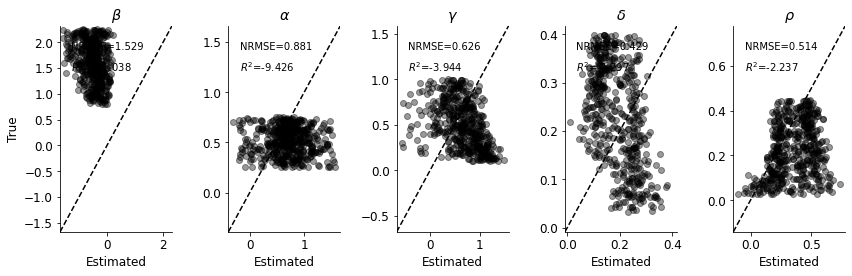

In [9]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, parameter_names, figsize=(12, 4))

### Manage checkpoints

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/SEIDR_eta/ckpt-292


### Training network

In [11]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(model=model, 
                            optimizer=optimizer,
                            loss_fn=maximum_likelihood_loss, 
                            iterations=iterations_per_epoch,
                            batch_size=batch_size,
                            p_bar=p_bar,
                            global_step=global_step) 

        # Manage checkpoint
        manager.save()

Training epoch 71: 100%|██████████| 1000/1000 [01:46<00:00,  9.39it/s, Iteration: 1000, Loss: -32.81004333496094]


Training epoch 100: 100%|██████████| 1000/1000 [01:46<00:00,  9.42it/s, Iteration: 1000, Loss: -32.70338439941406]


### Posterior means & Full posteriors

In [12]:
x_test.shape

(500, 500)

In [13]:
# Estimation sanity checks
theta_samples = model.sample(x_test, n_samples_posterior, to_numpy=True)
theta_approx_means = theta_samples.mean(axis=0)

In [14]:
ftheta_approx_means, ftheta_test, fx_test = est_sanity_checks(theta_approx_means, theta_test, x_test=x_test)

In [15]:
print(fx_test.shape)
print(ftheta_test.shape)
print(ftheta_approx_means.shape)

(383, 500)
(383, 5)
(383, 5)


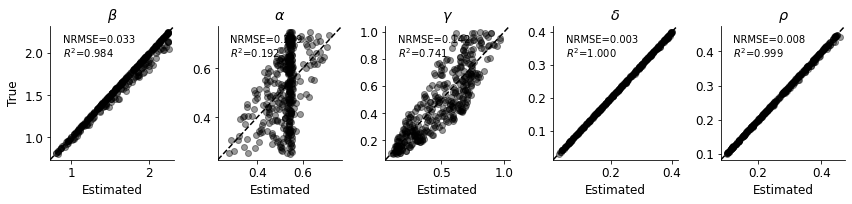

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


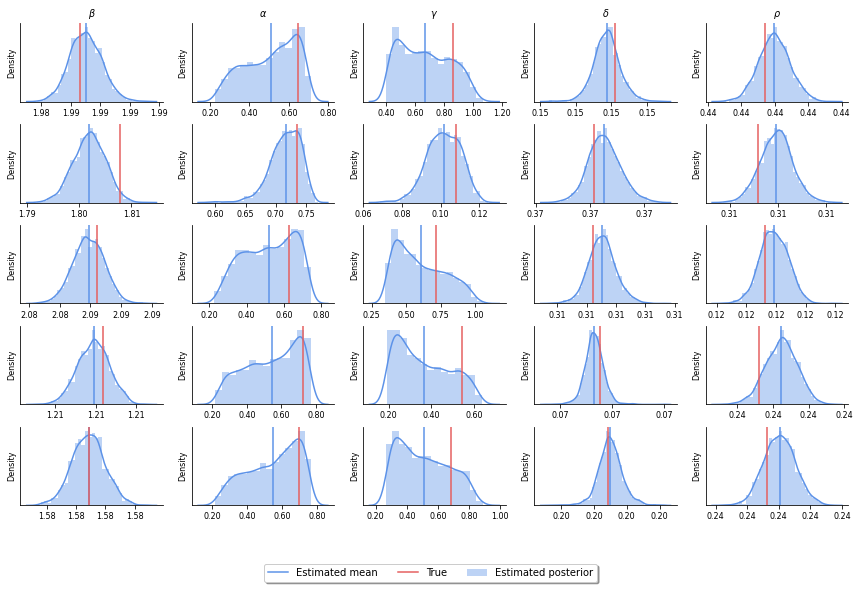

In [16]:
plot_true_est_scatter(model, fx_test, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=ftheta_approx_means)

plot_true_est_posterior(model, 2000, parameter_names, font_size=8,
                        X_test=fx_test[:5], 
                        theta_test=ftheta_test[:5], figsize=(12, 8))

What we have up to this point:
- x_test: array-like of shape (500, 500) -- 500 time series for 5 compartiments
- theta_samples: array-like of shape (n_samples_posterior, 500, 5) -- n_samples_posterior of tuples of parameter theta for the 500 time series. That is, for each time series of 5 compartiments, each sample of the n_samples_posterior will consist of 500 plausible tupples of parameters (each tuple consists of 5 parameters)

ToDo:

Iterate through all time series and exclude those parameters that are impossible (est sanity checks)
So, when iterating through all time series, an array-like of shape (n_samples_posterior, 1, 5) --> (n_samples_posterior, 5) is obtained. The posteriors are then compared with the ground truth estimations.

This array is filtered and used for resimulation

Resimulation: The time series are computed by passing the obtained and filtered array of tuples.
A total of fn_samples_posterior time series are simulated and compared with the posterior predictive

In [17]:
# Select random time series
sel_idx = np.random.choice(theta_samples.shape[1], 1, replace=False)

In [18]:
sel_theta_samples = theta_samples[:, sel_idx, :].squeeze()
sel_theta_test = theta_test[sel_idx, :].squeeze()
sel_x_test = x_test[sel_idx, :].squeeze().reshape(-1, 5)

In [19]:
# Sanity checks
fsel_theta_samples = sample_sanity_checks(sel_theta_samples)

In [20]:
print(sel_x_test.shape)
print(sel_theta_test.shape)
print(fsel_theta_samples.shape)

(100, 5)
(5,)
(1946, 5)


### Correlation of parameters

['$\\beta$', '$\\alpha$', '$\\gamma$', '$\\delta$', '$\\rho$']


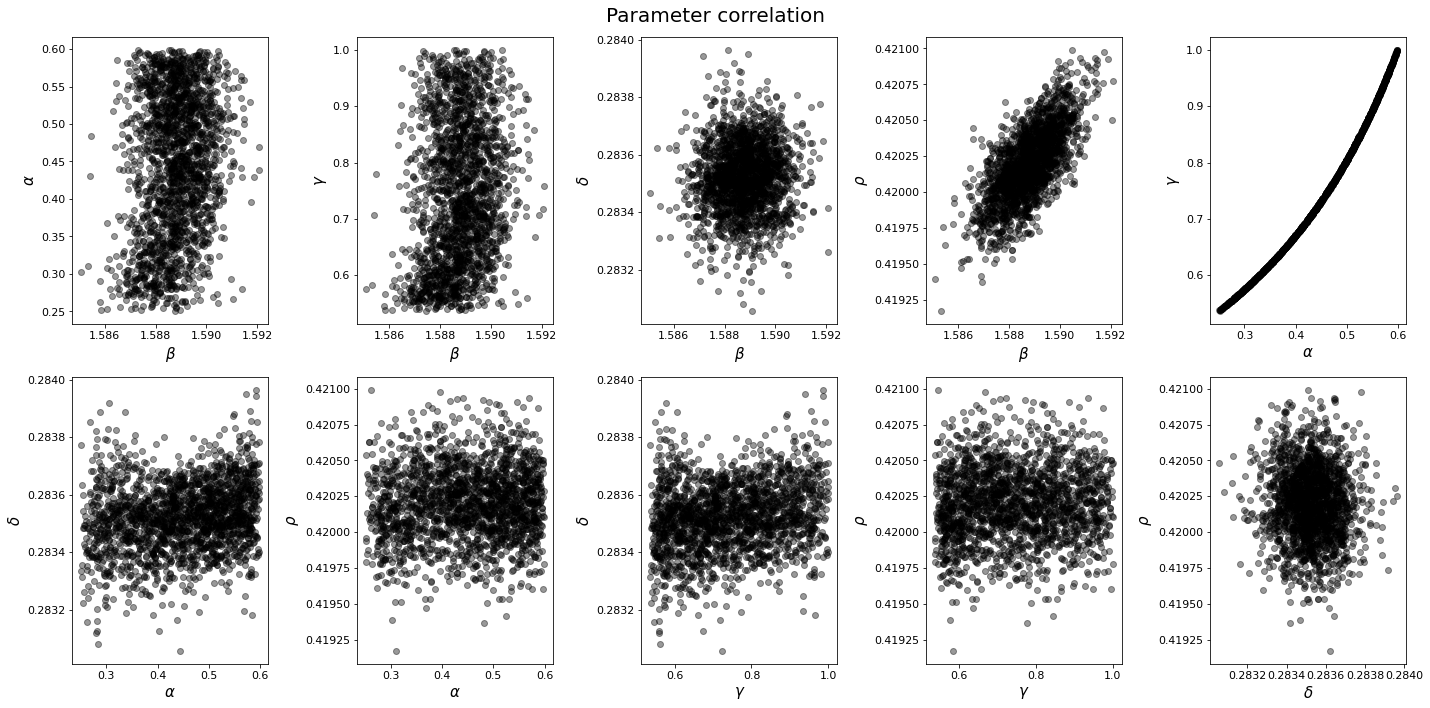

<Figure size 1440x720 with 0 Axes>

In [21]:
print(parameter_names)
plot_correlation_parameters(fsel_theta_samples, parameter_names)

### Ground-Truth comparison

In [22]:
# Ground-Truth comparison
# For each parameter compute NRMSE
nrmses = []
for i in range(5):
    # Compute NRMSE
    rmse = np.sqrt(np.mean((fsel_theta_samples[:, i] - sel_theta_test[i]) ** 2))
    nrmse = rmse / (sel_theta_test[i])
    nrmses.append(nrmse)

In [23]:
print("Ground-truth comparison (normalized root-mean-square deviation): \n{}".format(nrmses))

Ground-truth comparison (normalized root-mean-square deviation): 
[0.00063746586, 0.28478524, 0.25781643, 0.00047103423, 0.0006314861]


In [24]:
fsel_theta_samples.shape

(1946, 5)

In [25]:
# Resimulation
t_obs = 100
dt = 1
t = np.linspace(0, t_obs, int(t_obs/dt))
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(data_model, initial_values=init_vals)

In [26]:
ts = np.empty((fsel_theta_samples.shape[0], t_obs, 5))
for i in range(fsel_theta_samples.shape[0]):
    ts[i, :, :] = forward_model(fsel_theta_samples[i, :], t=t)

In [27]:
labels = ['S', 'E', 'I', 'R', 'D']
ts.shape

(1946, 100, 5)

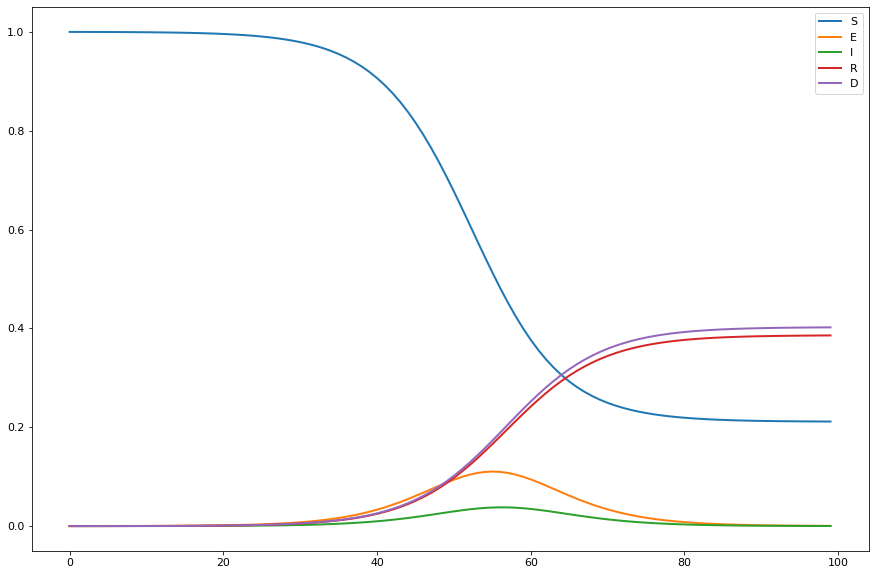

In [28]:
# Plot time series
plt.rcParams['font.size'] = 11
f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(5):
    ax.plot(ts[0, :, i], label=labels[i], lw=2)
    
plt.legend()

[0.09779263 0.10993091 0.12293877 0.13673053 0.15118338]
[0.09722883 0.10930859 0.12225873 0.13599268 0.15039544]
[0.0975186  0.10962835 0.12260914 0.1363733  0.15080275]


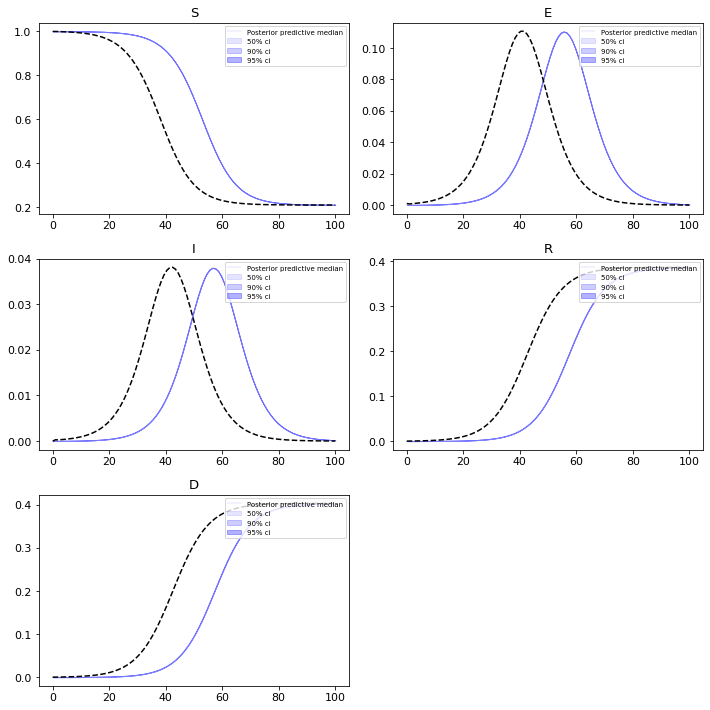

In [29]:
# Plot posterior predictive comparison of n random samples
cmap = cm.Blues
plot_ppc(t, ts, labels, sel_x_test, ps=True, cmedian='Blue')